In [1]:
import pandas as pd
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
from ast import literal_eval
from itertools import zip_longest
import numpy as np
from tabulate import tabulate

# For latex graphs
matplotlib.use("pgf")
matplotlib.rcParams.update({
    "pgf.texsystem": "pdflatex",
    'font.family': 'serif',
    'text.usetex': True,
    'pgf.rcfonts': False,
})

def plot_all_both(method):
    fig, axs = plt.subplots(2)
    fig.set_size_inches(w=5.39749, h=6)
    names = ["cellulitis", "copper", "search", "uti", "overdiagnosis"]
    for name in names:
        effort_accuracy_plot(name, method, True, axs[0])
        effort_accuracy_plot(name, method, False, axs[1])
    plt.xticks(np.arange(0, 1.1, 0.1))
    plt.yticks(np.arange(0.2, 1.1, 0.1))
    plt.legend()
    # plt.show()

def plot_all(method, show_all=True):
    fig = plt.figure()
    fig.set_size_inches(w=5.39749, h=3)
    names = ["cellulitis", "copper", "search", "uti", "overdiagnosis"]
    sns.set(style="whitegrid")
    for name in names:
        effort_accuracy_plot(name, method, show_all)
    plt.xticks(np.arange(0, 1.1, 0.1))
    plt.yticks(np.arange(0.2, 1.1, 0.1))
    plt.legend()
    # plt.show()
    
# Get the accuracy at a threshold effort
def get_accuracy(name, method, effort):
    stats_df = pd.read_csv("stats-" + name + "-" + method + ".csv")
    # Convert csv lists to actual lists
    stats_df.effort = stats_df.effort.apply(literal_eval)
    stats_df.accuracy = stats_df.accuracy.apply(literal_eval)

    # Find longest effort array
    avg_effort = max(stats_df.effort, key=len)
    # Average all accuracy data points over the 10 iterations
    avg_accuracy = np.nanmean(np.array(list(zip_longest(*stats_df.accuracy, fillvalue=1)),dtype=float), axis=1)
    
    # Find lowest index where accuracy exceeds or equals the accuracy
    index = np.argmax(avg_effort>=effort)
    return avg_accuracy[index]

def get_effort(name, method, accuracy):
    stats_df = pd.read_csv("stats-" + name + "-" + method + ".csv")
    # Convert csv lists to actual lists
    stats_df.effort = stats_df.effort.apply(literal_eval)
    stats_df.accuracy = stats_df.accuracy.apply(literal_eval)

    # Find longest effort array
    effort = max(stats_df.effort, key=len)
    # Average all accuracy data points over the 10 iterations
    avg_accuracy = np.nanmean(np.array(list(zip_longest(*stats_df.accuracy, fillvalue=1)),dtype=float), axis=1)
    
    # Find lowest index where accuracy exceeds or equals the accuracy
    index = np.argmax(avg_accuracy>=accuracy)
    return effort[index]
    
def print_table(method):
    table = []
    accuracies = [0.5, 0.75, 0.9, 1.0]
    names = ["cellulitis", "copper", "search", "uti", "overdiagnosis"]
    for name in names:
        row = [name]
        for accuracy in accuracies:
            row.append(get_effort(name, method, accuracy))
        table.append(row)
    print(tabulate(table, tablefmt='latex', floatfmt=".2f"))
    
def plot_table():
    table = []
    accuracies = [0.5, 0.75, 0.9, 1.0]
    names = ["cellulitis", "copper", "search", "uti", "overdiagnosis"]
    for name in names:
        for accuracy in accuracies:
            table.append([name, accuracy, get_effort(name, accuracy)])
    df = pd.DataFrame(table, columns=["name", "accuracy", "effort"])
    sns.set(style="whitegrid", rc={'figure.figsize':(5.39749, 3)})
    sns.barplot(x="accuracy", y="effort", hue="name", data=df)
    plt.xlabel("accuracy threshold")

def effort_accuracy_plot(name, method, show_all=True, plot=plt):
    stats_df = pd.read_csv("stats-" + name + "-" + method + ".csv")
    # Convert csv lists to actual lists
    stats_df.effort = stats_df.effort.apply(literal_eval)
    stats_df.accuracy = stats_df.accuracy.apply(literal_eval)

    # Find longest effort array
    effort = max(stats_df.effort, key=len)
    # Average all accuracy data points over the 10 iterations
    avg_accuracy = np.nanmean(np.array(list(zip_longest(*stats_df.accuracy, fillvalue=1)),dtype=float), axis=1).tolist()

    # Add values to show all
    if (show_all):
        effort.append(1)
        avg_accuracy.append(max(avg_accuracy))


    # Make plot look nice
    plt.xlabel("effort")
    plt.ylabel("accuracy")
    plot.plot(effort, avg_accuracy, label=name, linewidth=2)

C:\Users\Connor\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

The backend was *originally* set to 'module://ipykernel.pylab.backend_inline' by the following code:
  File "C:\Users\Connor\Anaconda3\lib\runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "C:\Users\Connor\Anaconda3\lib\runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "C:\Users\Connor\Anaconda3\lib\site-packages\ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "C:\Users\Connor\Anaconda3\lib\site-packages\traitlets\config\application.py", line 658, in launch_instance
    app.start()
  File "C:\Users\Connor\Anaconda3\lib\site-packages\ipykernel\kernelapp.py", line 486, in start
    self.io_loop.start()
  File "C:\Users\

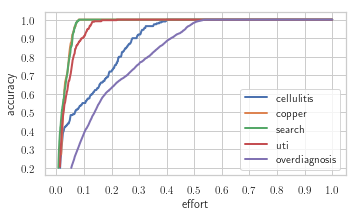

In [3]:
plot_all("simple", True)
# plt.savefig('../honours/advanced-topics-c/assets/all_plot.pgf')

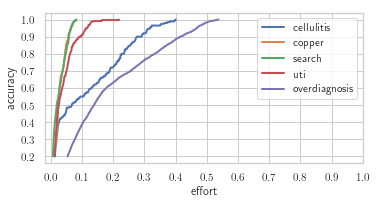

In [13]:
method = "simple"

plot_all(method, False)
plt.tight_layout()
plt.savefig('../honours/thesis/Figures/effort-accuracy-' + method + '.pgf')

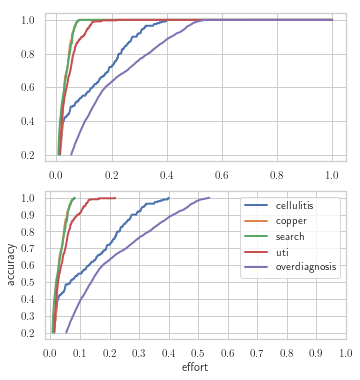

In [4]:
plot_all_both("simple")
# plt.savefig('../honours/advanced-topics-c/assets/all_plot_both.pgf')

In [6]:
print_table("simple")

\begin{tabular}{lrrrr}
\hline
 cellulitis    & 0.07 & 0.21 & 0.29 & 0.40 \\
 copper        & 0.03 & 0.04 & 0.06 & 0.08 \\
 search        & 0.02 & 0.04 & 0.06 & 0.08 \\
 uti           & 0.03 & 0.06 & 0.09 & 0.22 \\
 overdiagnosis & 0.14 & 0.29 & 0.42 & 0.54 \\
\hline
\end{tabular}


In [2]:
plot_table()
plt.tight_layout()
# plt.savefig('../honours/advanced-topics-c/assets/table_plot.pgf')

In [ ]:
effort_accuracy_plot("cellulitis")

In [ ]:
effort_accuracy_plot("copper")

In [ ]:
effort_accuracy_plot("overdiagnosis")

In [ ]:
effort_accuracy_plot("search")

In [ ]:
effort_accuracy_plot("uti")